In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.keras.utils.vis_utils import plot_model

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
print(tf.__version__)
import os

base_dir  = "/Users/sfazalur/Desktop/ECS174_Project/DATASET"
train_dir = os.path.join(base_dir, "TRAIN")
val_dir   = os.path.join(base_dir, "TEST")

print("Train dir:", train_dir)
print("Val dir:", val_dir)
print("Train exists?", os.path.exists(train_dir))
print("Val exists?", os.path.exists(val_dir))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2.20.0
Train dir: /Users/sfazalur/Desktop/ECS174_Project/DATASET/TRAIN
Val dir: /Users/sfazalur/Desktop/ECS174_Project/DATASET/TEST
Train exists? True
Val exists? True


In [11]:
# train_dir = "DATASET/TRAIN"
# val_dir = "DATASET/TEST"

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2, 
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.5
)

train_set = train_datagen.flow_from_directory(
    train_dir,
    class_mode='binary',
    batch_size=32,
    target_size=(65, 65)
)

val_set = val_datagen.flow_from_directory(
    val_dir,
    class_mode='binary',
    batch_size=32,
    target_size=(65, 65),
    subset='training'
)

test_set = val_datagen.flow_from_directory(
    val_dir,
    class_mode='binary',
    batch_size=32,
    target_size=(65, 65),
    subset='validation'
)


Found 22564 images belonging to 2 classes.
Found 1257 images belonging to 2 classes.
Found 1256 images belonging to 2 classes.


In [12]:
def conv_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, 3, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    return x

In [13]:
def create_model():
    inputs = tf.keras.Input(shape=(65, 65, 3))
    
    x = conv_block(inputs, 32)
    x = conv_block(x, 64)
    x = conv_block(x, 128)
    x = conv_block(x, 256)

    
    x = tf.keras.layers.Flatten()(x)
    
    x = tf.keras.layers.Dense(4096, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
        
    x = tf.keras.layers.Dense(4096, activation = 'relu')(x)
    
    output = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
    
    func_model = tf.keras.models.Model(inputs = inputs, outputs=output)
    
    return func_model

In [14]:
model = create_model()

In [15]:
METRICS = [
          'accuracy',
          tf.metrics.TruePositives(name='tp'),
          tf.metrics.FalsePositives(name='fp'),
          tf.metrics.TrueNegatives(name='tn'),
          tf.metrics.FalseNegatives(name='fn'), 
          tf.metrics.Precision(name='precision'),
          tf.metrics.Recall(name='recall'),
          
    ]
adam = tf.keras.optimizers.Adam()    
model.compile(optimizer = adam, loss ='binary_crossentropy', metrics = METRICS)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3
                                                  , patience=5, verbose=2, 
                                                  mode='max')


history = model.fit(train_set, validation_data = val_set, epochs = 30, 
                    callbacks=[lr_reduce])

Epoch 1/30
706/706 ━━━━━━━━━━━━━━━━━━━━ 92s 127ms/step - accuracy: 0.7968 - fn: 2474.0000 - fp: 2110.0000 - loss: 0.6373 - precision: 0.7810 - recall: 0.7526 - tn: 10455.0000 - tp: 7525.0000 - val_accuracy: 0.8305 - val_fn: 175.0000 - val_fp: 38.0000 - val_loss: 0.5214 - val_precision: 0.9093 - val_recall: 0.6853 - val_tn: 663.0000 - val_tp: 381.0000 - learning_rate: 0.0010
Epoch 2/30
706/706 ━━━━━━━━━━━━━━━━━━━━ 89s 126ms/step - accuracy: 0.8246 - fn: 2232.0000 - fp: 1726.0000 - loss: 0.4184 - precision: 0.8182 - recall: 0.7768 - tn: 10839.0000 - tp: 7767.0000 - val_accuracy: 0.7669 - val_fn: 110.0000 - val_fp: 183.0000 - val_loss: 0.5187 - val_precision: 0.7091 - val_recall: 0.8022 - val_tn: 518.0000 - val_tp: 446.0000 - learning_rate: 0.0010
Epoch 3/30
706/706 ━━━━━━━━━━━━━━━━━━━━ 90s 127ms/step - accuracy: 0.8335 - fn: 2033.0000 - fp: 1725.0000 - loss: 0.3992 - precision: 0.8220 - recall: 0.7967 - tn: 10840.0000 - tp: 7966.0000 - val_accuracy: 0.8791 - val_fn: 106.0000 - val_fp: 46

In [16]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 65, 65, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 65, 65, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 65, 65, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 65, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,869,253 (388.60 MB)

 Trainable params: 33,956,097 (129.53 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 67,912,196 (259.06 MB)

In [17]:
model.evaluate(test_set)


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9148 - fn: 58.0000 - fp: 49.0000 - loss: 0.2448 - precision: 0.9104 - recall: 0.8957 - tn: 651.0000 - tp: 498.0000


[0.24478647112846375,
 0.9148089289665222,
 498.0,
 49.0,
 651.0,
 58.0,
 0.9104204773902893,
 0.8956834673881531]

Text(0.5, 1.0, 'Training and validation loss')

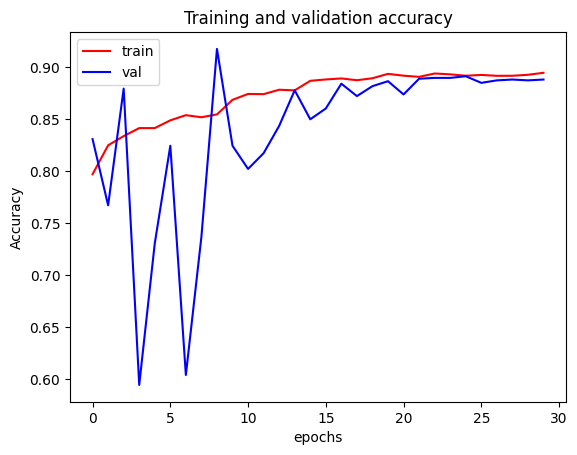

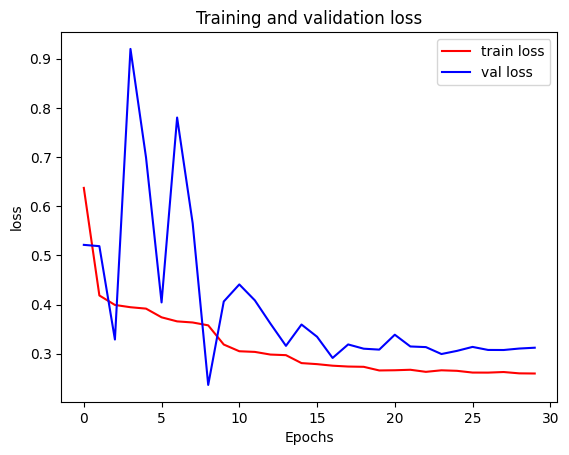

In [18]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
#print(history.history['lr'])
epochs=range(len(acc)) # Get number of epochs
rec = history.history['recall']
per = history.history['precision']
val_rec = history.history['val_recall']
val_perc = history.history['val_precision']



# Plot training and validation accuracy per epoch
plt.figure()

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'])
plt.title('Training and validation accuracy')


# Plot training and validation loss per epoch
plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(['train loss', 'val loss'])
plt.title('Training and validation loss')

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

Final Model Performance Summary (Baseline CNN, Keras):
------------------------------------------------------------
Best Validation Loss: 0.2364
Final Metrics:
accuracy : 91.4809
precision: 0.9104
recall: 0.8957
f1 : 0.4080
auc_roc: 0.4771

Per-class Performance Metrics:
------------------------------------------------------------

Class: O
Precision: 0.5331
Recall : 0.5400
F1-Score : 0.5366

Class: R
Precision: 0.4113
Recall : 0.4047
F1-Score : 0.4080


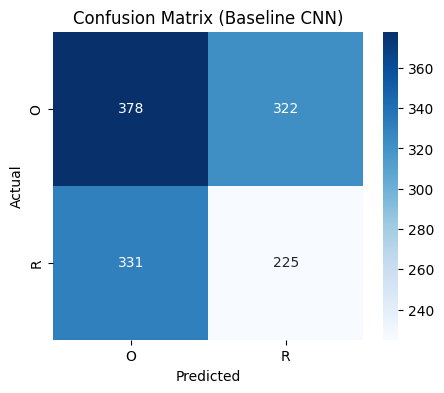

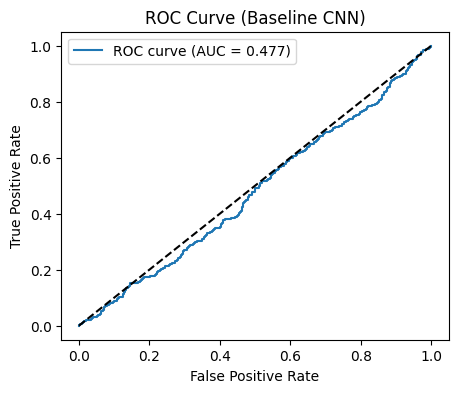

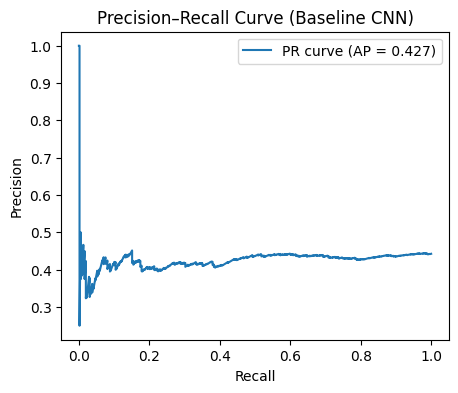

In [ ]:
#to get the same metrics as other model
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, precision_recall_fscore_support, confusion_matrix, precision_recall_curve, roc_curve, average_precision_score
)
import numpy as np
import seaborn as sns

best_val_loss = float(np.min(val_loss))  

# run one clean evaluation on the test set to get the built-in Keras metrics
test_results = model.evaluate(test_set, verbose=0)
test_loss = test_results[0]
test_accuracy = test_results[1]
tp=test_results[2]
fp= test_results[3]
tn= test_results[4]
fn= test_results[5]
test_precision = test_results[6]
test_recall = test_results[7]

y_true= test_set.classes                   
y_prob= model.predict(test_set).ravel()     # predicted probs for class 1
y_pred= (y_prob >= 0.5).astype(int)         # threshold at 0.5

# metrics
test_f1  = f1_score(y_true, y_pred, average="binary")
test_auc = roc_auc_score(y_true, y_prob)

print("\nFinal Model Performance Summary (Baseline CNN, Keras):")
print("-" * 60)
print(f"Best Validation Loss: {best_val_loss:.4f}")
print("Final Metrics:")
print(f"accuracy : {test_accuracy*100:.4f}")
print(f"precision: {test_precision:.4f}")
print(f"recall: {test_recall:.4f}")
print(f"f1 : {test_f1:.4f}")
print(f"auc_roc: {test_auc:.4f}")

#  Per-class metrics 
class_names = sorted(test_set.class_indices, key=test_set.class_indices.get)
precisions, recalls, f1s, supports = precision_recall_fscore_support(
    y_true, y_pred, labels=[0, 1], zero_division=0
)

print("\nPer-class Performance Metrics:")
print("-" * 60)
for idx, name in enumerate(class_names):
    print(f"\nClass: {name}")
    print(f"Precision: {precisions[idx]:.4f}")
    print(f"Recall : {recalls[idx]:.4f}")
    print(f"F1-Score : {f1s[idx]:.4f}")

#Confusion Matrix 
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Baseline CNN)")
plt.show()

# ROC Curve 
fpr, tpr, _ = roc_curve(y_true, y_prob)
auc_val = roc_auc_score(y_true, y_prob)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_val:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Baseline CNN)")
plt.legend()
plt.show()

# Precision–Recall Curve
prec, rec, _ = precision_recall_curve(y_true, y_prob)
ap_val = average_precision_score(y_true, y_prob)

plt.figure(figsize=(5, 4))
plt.plot(rec, prec, label=f"PR curve (AP = {ap_val:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Baseline CNN)")
plt.legend()
plt.show()